#      Does a college basketball team perform better when their mascot is Human or Non-Human in the NCAA basketball Tournament?
### -This report will take the results from every NCAA Tournamnet game since the 1985 season and compare whether teams with Non-Human or Human mascots win more

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

#### Below I will be creating the following dataframes from .csv files from Kaggle about NCAA Basketball Tournamnet Teams:
    mascots_df- shows the teams as well as their respective mascots
    colors_df- shows the teams with their team colors 
    tourny_df- shows the teams, scores of earch team in the game, seeds and other data not used
#### I will also take the above dataframes and create SQL databases to query them down to managable sizes to manipulate

### Mascots 

In [2]:
df1_df = pd.read_csv("team_mascots.csv", delimiter = ',')
df1_df.to_sql("mascot_table", sqlite3.connect("teamMascots.db"), if_exists = "replace")

con = sqlite3.connect("teamMascots.db")
mascots_df =pd.read_sql_query("SELECT id, market, name, mascot, mascot_name, mascot_common_name FROM mascot_table", con)
mascots_df.head()

,id,market,name,mascot,mascot_name,mascot_common_name
0,2959bd24-7007-41ae-a3a3-abdf26888cfc,Tulsa,Golden Hurricane,Hurricane,Captain Cane,Hurricane
1,ad4bc983-8d2e-4e6f-a8f9-80840a786c64,Arizona State,Sun Devils,Devil,Sparky,Devil
2,f2d01b77-0f5d-4574-9e49-2a3eaf822e44,Drexel,Dragons,Dragon,Mario the Magnificent,Dragon
3,b47d10b8-a2a5-47df-a2f9-7bd0b9d51beb,Bradley,Braves,Gargoyle,Kaboom!,Gargoyle
4,0113eea0-c943-4fff-9780-ae0fb099e7ef,Canisius,Golden Griffins,Griffin,Petey,Griffin


### Team Colors

In [3]:
df2 = pd.read_csv("team_colors.csv", delimiter = ',')
df2.to_sql("colors_table", sqlite3.connect("teamColors.db"), if_exists = "replace")

con = sqlite3.connect("teamColors.db")
colors_df = pd.read_sql_query("SELECT market,id,code_ncaa,color FROM colors_table", con)
colors_df.head()

,market,id,code_ncaa,color
0,Milwaukee,5d77800f-1ae6-4b66-8e97-b0dbb8bbc717,797,#000000
1,Colorado,9fccbf28-2858-4263-821c-fdefb3c7efa3,157,#000000
2,Northeastern,93df9b18-e9fc-42a7-bb45-a736c203b4dc,500,#000000
3,Georgia Southern,6b955b96-b736-475e-bffd-e4acf2054169,253,#000066
4,Richmond,9b66e1e0-aace-4671-9be2-54c8acf5ecfc,575,#000066


### Team Tournamnet Stats

In [4]:
df3 = pd.read_csv("tourny_stats.csv", delimiter = ',')
df3.to_sql("stats_table", sqlite3.connect("teamStats.db"), if_exists = "replace")

con = sqlite3.connect("teamStats.db")
tourny_df = pd.read_sql_query("SELECT seed, team, score, seed_2, team_2, score_2  FROM stats_table", con)
tourny_df.head()

,seed,team,score,seed_2,team_2,score_2
0,1,St Johns,83,16,Southern,59
1,2,VCU,81,15,Marshall,65
2,3,Illinois,76,14,Northeastern,57
3,4,Loyola Illinois,59,13,Iona,58
4,5,SMU,85,12,Old Dominion,68


### Since the data that we are using doesnt have a 'winner' column we have to do some math. We will get the list of team_1 victors and then we will get the team_2 victors and combine the two dataframes to make one full list of victors

In [5]:
#taking the tournament past results and filtering it so team_2 wins
tourny_wins_df = tourny_df.where(tourny_df["score"] < tourny_df["score_2"],"FALSE")
tourny_wins_df

#return those teams into new df "teams2" and just showing the winning team
tourny_teams2 = tourny_wins_df[tourny_wins_df.team != 'FALSE']
teams2_df = tourny_teams2.iloc[:,3:5]
teams2_df.columns = ['seed', 'team']
teams2_df.head()

,seed,team
14,11,Boston College
16,9,Illinois St
20,13,Navy
22,11,Auburn
27,7,Alabama


In [6]:
#taking the tournament past results and filtering it so team_1 wins
tourny_wins_df = tourny_df.where(tourny_df["score"] > tourny_df["score_2"],"FALSE")
tourny_wins_df

#return those teams into new df "teams2" and just showing the winning team
tourny_teams1 = tourny_wins_df[tourny_wins_df != 'FALSE']
teams1_df = tourny_teams1.iloc[:,0:2]
teams1_df.head()

,seed,team
0,1,St Johns
1,2,VCU
2,3,Illinois
3,4,Loyola Illinois
4,5,SMU


### Now below are all the instances where a team has won a NCAA Tourny Game since 1985 (mulitples included) combining team1 wins and team2 wins

In [7]:
all_team_wins_df= teams1_df.append(teams2_df)
team_wins_df = all_team_wins_df.dropna()
teams_sorted = team_wins_df.sort_values('team', ascending=True)
teams_sorted.head()

,seed,team
124,5,Alabama
453,5,Alabama
56,7,Alabama
2102,9,Alabama
143,2,Alabama


## With the team wins tallied we are now able to see a list of teams with the most wins since 1985 as stated below:

In [8]:
team_tally_df = teams_sorted['team'].value_counts().to_frame('win_count').rename_axis('team').reset_index()
team_tally_df.head()

,team,win_count
0,Duke,94
1,North Carolina,89
2,Kansas,84
3,Kentucky,80
4,Connecticut,55


## Since we now have a list of total wins by teams we can perform some stats on the list:
### - As you can see the vast majority of teams fall well below the 20 win mark with an average of 11 wins
### - With a standard deviation of 17 wins this shows the great discrepency of the outliers present 

In [9]:
#statistics of the win counts seperating every team
team_tally_df.describe().T 
#.T changes stat layout from rows to columns

,count,mean,std,min,25%,50%,75%,max
win_count,179.0,11.96648,16.993356,1.0,2.0,4.0,16.0,94.0


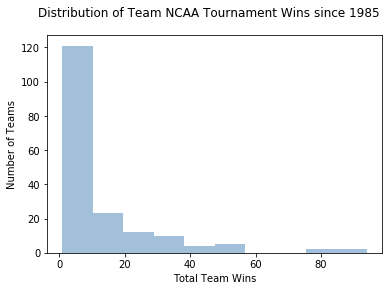

In [10]:
ax = plt.hist(team_tally_df['win_count'], alpha=0.5,
                histtype='stepfilled', color='steelblue',
                edgecolor='none')
plt.xlabel('Total Team Wins')
plt.ylabel('Number of Teams')
plt.suptitle("Distribution of Team NCAA Tournament Wins since 1985")
plt.show()

## So here we have, in bar chart form, the top 25 college basketball teams in terms of NCAA Tournament Wins since 1985

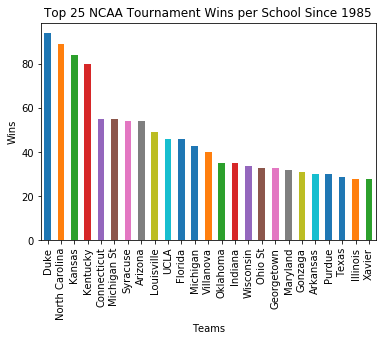

In [11]:
ax = teams_sorted['team'].value_counts().head(25).plot('bar', title= 'Top 25 NCAA Tournament Wins per School Since 1985')
ax.set_xlabel("Teams")
ax.set_ylabel("Wins")
plt.show()

### Next we have to use the above data and filter out the Mascot Data frame with only the teams that have won an NCAA Tournamnet game

In [12]:
mascot_wins_df = mascots_df.loc[mascots_df.market.isin(teams_sorted['team'])]
mascot_wins_df.head()

,id,market,name,mascot,mascot_name,mascot_common_name
0,2959bd24-7007-41ae-a3a3-abdf26888cfc,Tulsa,Golden Hurricane,Hurricane,Captain Cane,Hurricane
2,f2d01b77-0f5d-4574-9e49-2a3eaf822e44,Drexel,Dragons,Dragon,Mario the Magnificent,Dragon
3,b47d10b8-a2a5-47df-a2f9-7bd0b9d51beb,Bradley,Braves,Gargoyle,Kaboom!,Gargoyle
5,bdc2561d-f603-4fab-a262-f1d2af462277,Michigan,Wolverines,None,None,Wolverine
10,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,Wake Forest,Demon Deacons,Demon,Demon Deacon,Demon


### Once the mascots have been filtered out we can merge the mascot's "common name" with the team name and win counts

In [13]:
mascot_wins_split_df = pd.merge(mascot_wins_df, team_tally_df, how="left", left_on=["market"], right_on=["team"])
sorted_mascot_wins = mascot_wins_split_df[["id","team","mascot_common_name",
                                           "win_count"]].sort_values('win_count', ascending=False)
sorted_mascot_wins.head(10)

,id,team,mascot_common_name,win_count
15,faeb1160-5d15-4f26-99fc-c441cf21fc7f,Duke,Blue Devil,94
108,e9ca48b2-00ba-41c0-a02b-6885a2da1ff1,North Carolina,Sheep,89
11,fae4855b-1b64-4b40-a632-9ed345e1e952,Kansas,Jayhawk,84
69,2267a1f4-68f6-418b-aaf6-2aa0c4b291f1,Kentucky,Wildcat,80
88,efba5350-79bc-47aa-a189-db177b95b491,Connecticut,Domestic dog,55
97,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,Syracuse,Orange,54
71,9b166a3f-e64b-4825-bb6b-92c6f0418263,Arizona,Wildcat,54
115,b795ddbc-baab-4499-8803-52e8608520ab,Louisville,Cardinal,49
96,912f8837-1d81-4ef9-a576-a21f271d4c64,Florida,Alligator,46
76,ec0d6b67-4b16-4b50-92b2-1a651dae6b0f,UCLA,Brown Bear,46


### Now we will further catagorize the mascot names by being either Human or Non-Human and sorting then 

In [14]:
sorted_mascot_wins['mascot_type'] = np.where(sorted_mascot_wins['mascot_common_name']=='Human', 'Human', 'Non_Human')
sorted_mascot_wins.sort_values('mascot_type', ascending=False)
sorted_mascot_wins.head()

,id,team,mascot_common_name,win_count,mascot_type
15,faeb1160-5d15-4f26-99fc-c441cf21fc7f,Duke,Blue Devil,94,Non_Human
108,e9ca48b2-00ba-41c0-a02b-6885a2da1ff1,North Carolina,Sheep,89,Non_Human
11,fae4855b-1b64-4b40-a632-9ed345e1e952,Kansas,Jayhawk,84,Non_Human
69,2267a1f4-68f6-418b-aaf6-2aa0c4b291f1,Kentucky,Wildcat,80,Non_Human
88,efba5350-79bc-47aa-a189-db177b95b491,Connecticut,Domestic dog,55,Non_Human


### After catagorizing our mascot types we can now count how many are in the dataframe and return a tally of each.

In [15]:
mascot_tally = sorted_mascot_wins.groupby(['mascot_type'])["win_count"].sum()
mascot_tally

mascot_type
Human         303
Non_Human    1436
Name: win_count, dtype: int64

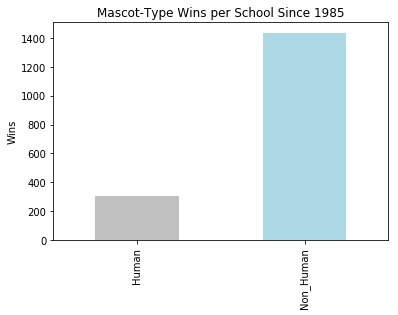

In [16]:
#creating a bar chart depicting the difference of human and non-human wins

ax = mascot_tally.plot('bar', color = ['silver','lightblue'], 
                       fontsize=10,  title= 'Mascot-Type Wins per School Since 1985')
ax.set_xlabel("")
ax.set_ylabel("Wins")
plt.show()

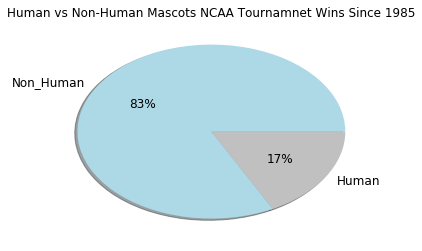

In [17]:
#creating a pie chart depicting the ratio of human and non-human wins

ax= mascot_tally.plot('pie', shadow=True, counterclock=False, colors = ['silver','lightblue'], fontsize=12,
                  autopct='%1.0f%%', title= 'Human vs Non-Human Mascots NCAA Tournamnet Wins Since 1985')
ax.set_ylabel('')
plt.show()

### In conclusion the data presented in this report shows that there is in fact a trend, at least on the surface, showing Non-Human Mascots win about 83% more often than Human Mascots.
### However, there are clear arguments that this correlation shouldn't bear much weight especially since the "Top 25 Wins per Team" and the "win distribution" graphs show that the top 10 teams in history are Non-Human Mascots which are skewing the data towards the Non-Humans.
### Things to consider moving forwards to further this study:
#### - Adding wins from the NCAA Tournament previous to 1985
#### - Schools recruiting class rankings
#### - Conference performances
#### - Potentially looking at wins from the entire seasons to have a larger sample size